# 预测新图像

使用训练好的苹果新鲜度检测模型，对我们在博达校区实地拍摄的图片进行预测。


## 导入工具包

In [1]:
import torch
import torchvision
import torch.nn.functional as F

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cpu')

## 设置matplotlib中文字体

In [3]:
# Linux操作系统，例如 云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1
# 如果遇到 SSL 相关报错，重新运行本代码块即可
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf -O /environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf
!rm -rf /home/featurize/.cache/matplotlib

import matplotlib
matplotlib.rc("font",family='SimHei') # 中文字体


## 载入类别

In [4]:
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()

In [5]:
idx_to_labels

{0: 'freshapples', 1: 'rottenapples'}

## 导入训练好的模型

In [6]:
model = torch.load('checkpoints/apple_freshness_zhou.pth')
model = model.eval().to(device)

## 预处理

In [7]:
from torchvision import transforms
# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 载入一张测试图像

In [8]:
from PIL import Image

In [101]:
# img_path = 'test_img/apples.jpg'
# img_path = 'test_img/freshapple.png'
# img_path = 'test_img/rottenapple.jpg'
# img_path = 'test_img/1.jpeg'
# img_path = 'test_img/2.jpeg'
img_path = 'test_img/7.jpeg'

In [102]:
img_pil = Image.open(img_path)

In [103]:
np.array(img_pil).shape

(391, 500, 3)

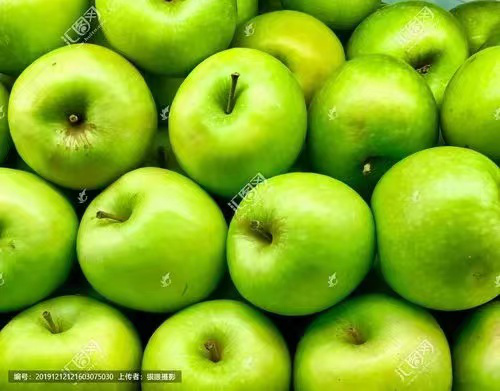

In [104]:
img_pil

## 预处理、前向预测

In [105]:
input_img = test_transform(img_pil) # 预处理

In [106]:
input_img.shape

torch.Size([3, 224, 224])

In [107]:
input_img = input_img.unsqueeze(0).to(device)

In [108]:
input_img.shape

torch.Size([1, 3, 224, 224])

In [109]:
# 执行前向预测，得到所有类别的 logit 预测分数
pred_logits = model(input_img) 

In [110]:
pred_logits

tensor([[ 0.4669, -0.4642]], grad_fn=<AddmmBackward0>)

In [111]:
pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算

In [112]:
pred_softmax

tensor([[0.7173, 0.2827]], grad_fn=<SoftmaxBackward0>)

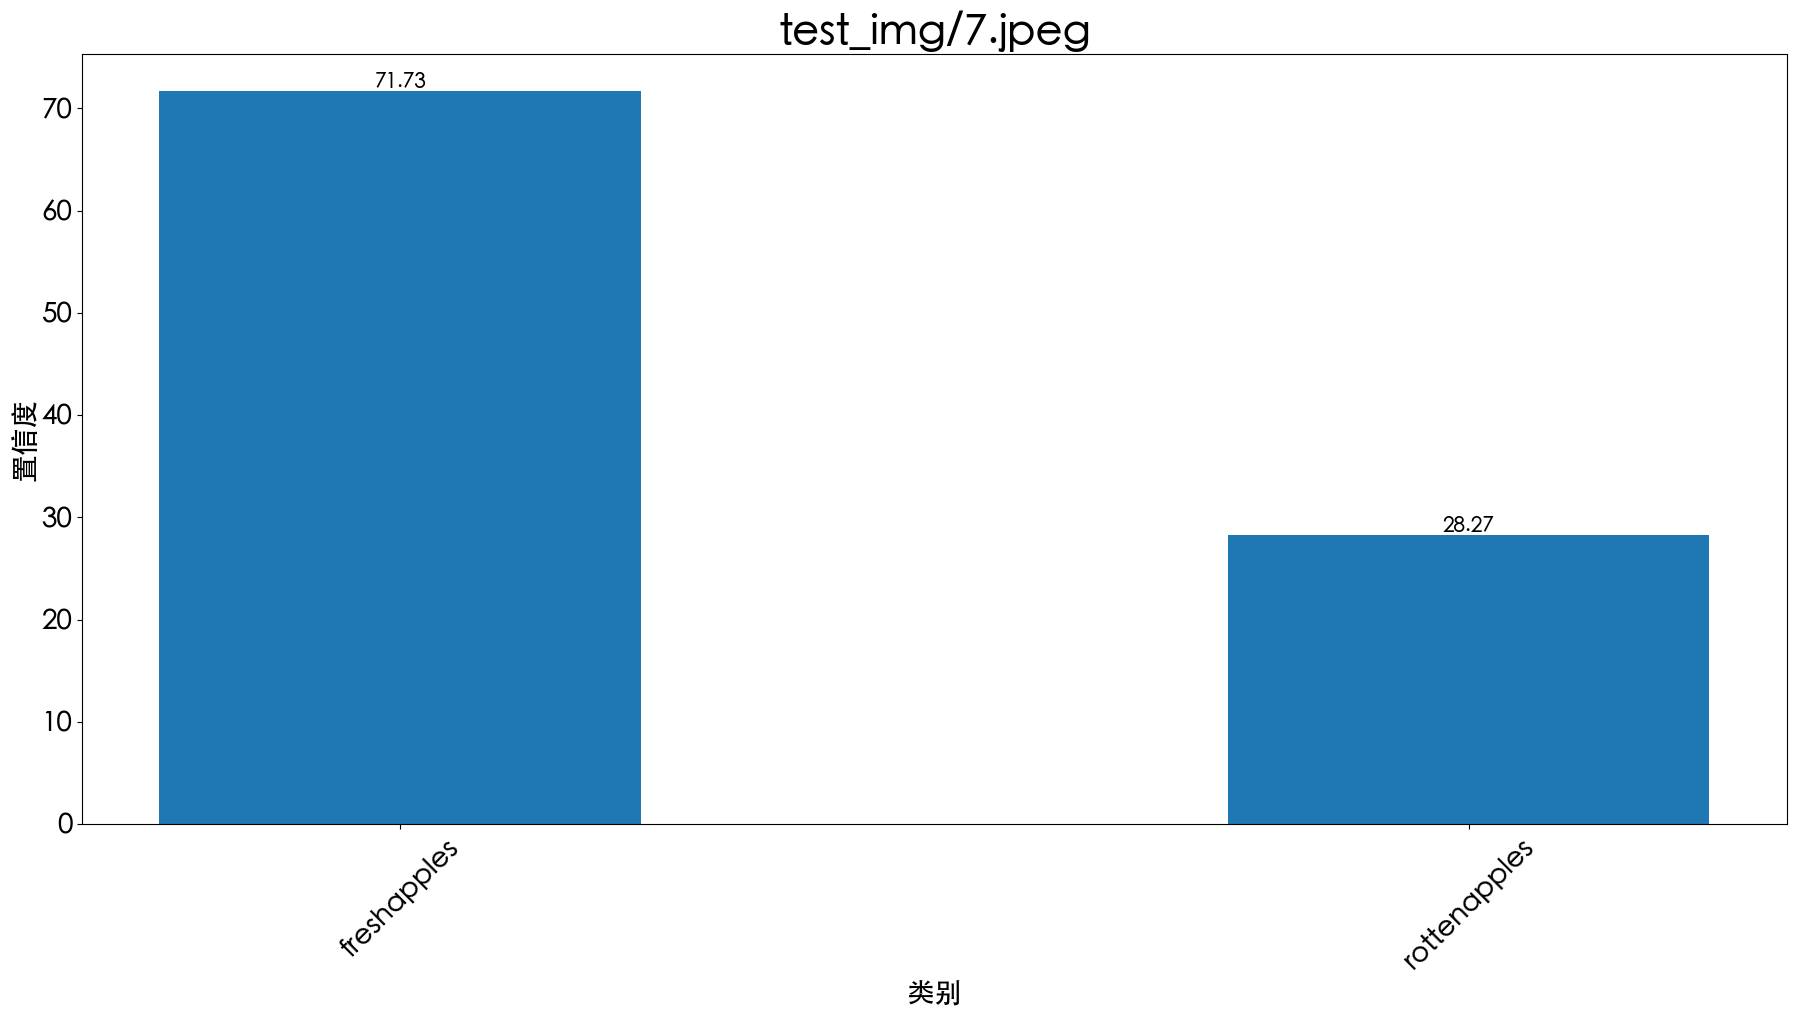

In [113]:
# 设置中文字体
import matplotlib
a=sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family']=['Heiti TC']
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号



plt.figure(figsize=(22, 10))

x = idx_to_labels.values()
y = pred_softmax.cpu().detach().numpy()[0] * 100
width = 0.45 # 柱状图宽度

ax = plt.bar(x, y, width)

plt.bar_label(ax, fmt='%.2f', fontsize=15) # 置信度数值
plt.tick_params(labelsize=20) # 设置坐标文字大小

plt.title(img_path, fontsize=30)
plt.xticks(rotation=45) # 横轴文字旋转
plt.xlabel('类别', fontsize=20)
plt.ylabel('置信度', fontsize=20)
plt.show()

## 置信度最大的前 n 个结果

In [96]:
n = 2
top_n = torch.topk(pred_softmax, n) # 取置信度最大的 n 个结果
pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析出类别
confs = top_n[0].cpu().detach().numpy().squeeze() # 解析出置信度

In [97]:
pred_ids

array([0, 1])

In [98]:
confs

array([0.93318987, 0.06681013], dtype=float32)

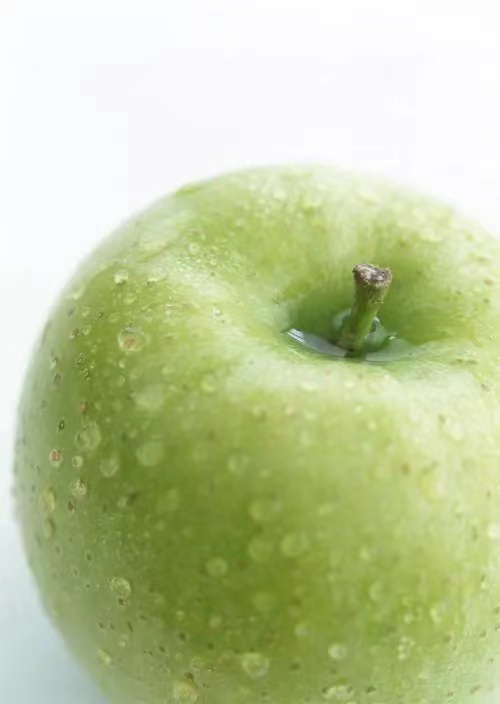

In [99]:
img_pil

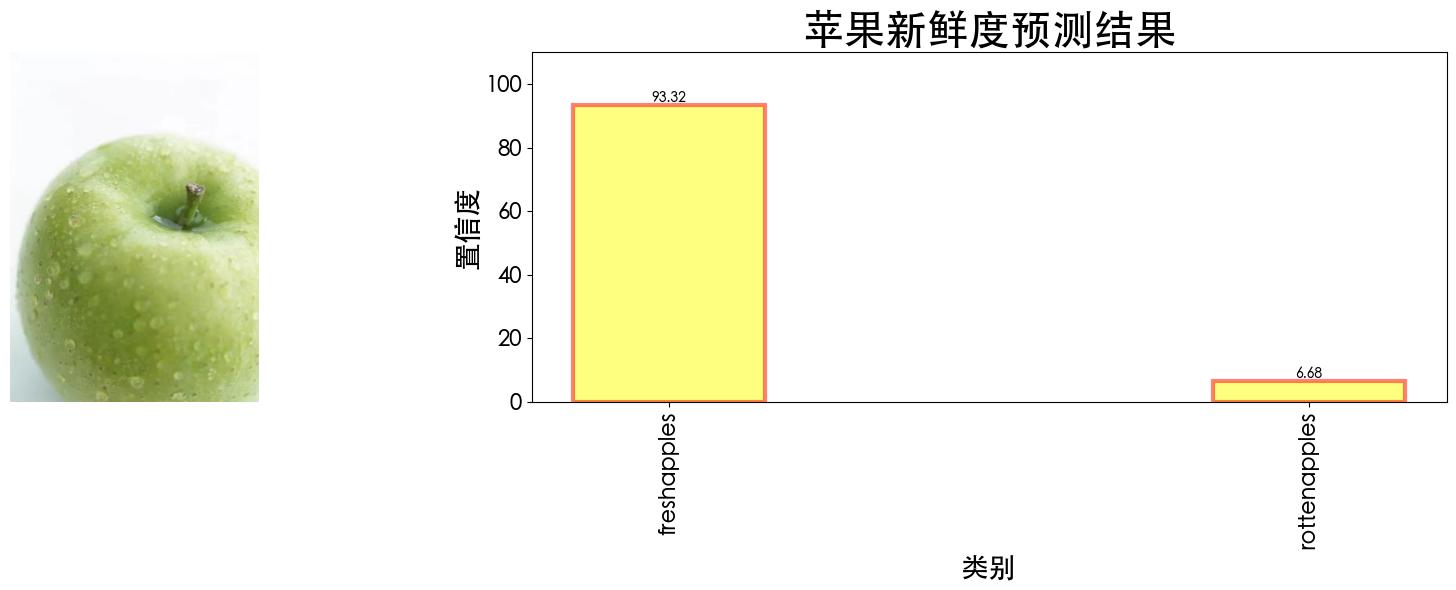

In [100]:
fig = plt.figure(figsize=(18,6))

# 绘制左图-预测图
ax1 = plt.subplot(1,2,1)
ax1.imshow(img_pil)
ax1.axis('off')

# 绘制右图-柱状图
ax2 = plt.subplot(1,2,2)
x = idx_to_labels.values()
y = pred_softmax.cpu().detach().numpy()[0] * 100
ax2.bar(x, y, alpha=0.5, width=0.3, color='yellow', edgecolor='red', lw=3)
plt.bar_label(ax, fmt='%.2f', fontsize=10) # 置信度数值

plt.title('苹果新鲜度预测结果'.format(img_path), fontsize=30)
plt.xlabel('类别', fontsize=20)
plt.ylabel('置信度', fontsize=20)
plt.ylim([0, 110]) # y轴取值范围
ax2.tick_params(labelsize=16) # 坐标文字大小
plt.xticks(rotation=90) # 横轴文字旋转

plt.tight_layout()
fig.savefig('output/预测图+柱状图.jpg')